### Exploratory Data Analysis of Group Psychotherapy Transcripts

- Joel Stremmel
- 04-02-23

##### About

This notebook explores the 10 group psychotherapy transcripts provided by Martin on 03-31-23.  It describes the number of words per transcript as well as the number of words spoken by each participant across transcripts.

##### Imports

In [1]:
import os
import re
import glob
import statistics
import matplotlib.pyplot as plt
from collections import defaultdict
from pdfminer.high_level import extract_text

##### Set Parameters

In [2]:
pdf_dir = './session_transcripts_iteration_2'
speakers = [
    'Lisa Brownstone (She/Her)',
    'Betty_2',
    'Martha_2',
    'Tanya_2',
    'Bonnie_2',
    'Sharon_2',
    'Hannah Norling (she/her)',
    'Cecilia_2',
    'Maya_2',
    'Devin Kelly (she/her/hers)',
    'Addison_2',
    'Penny_2'
]

##### Collect PDFs of Transcripts

In [3]:
pdf_files = glob.glob(os.path.join(pdf_dir, '*.pdf'))

##### Extract PDF Text and Count Words

./session_transcripts_iteration_2/WDS2.7 Transcript.pdf - Number of words: 6450
./session_transcripts_iteration_2/WDS2.3 Transcript.pdf - Number of words: 6637
./session_transcripts_iteration_2/WDS2.TEN Transcript.pdf - Number of words: 5445
./session_transcripts_iteration_2/WDS2.2 Transcript.pdf - Number of words: 6753
./session_transcripts_iteration_2/WDS2.9 Transcript.pdf - Number of words: 6743
./session_transcripts_iteration_2/WDS2.5 Transcript.pdf - Number of words: 6541
./session_transcripts_iteration_2/WDS2.8 Transcript.pdf - Number of words: 5266
./session_transcripts_iteration_2/WDS2.4 Transcript.pdf - Number of words: 6737
./session_transcripts_iteration_2/WDS2.1 Transcript.pdf - Number of words: 8219
./session_transcripts_iteration_2/WDS2.6 Transcript.pdf - Number of words: 7273

Number of documents: 10
Mean number of words per document: 6606.40
Standard deviation of number of words per document: 835.15


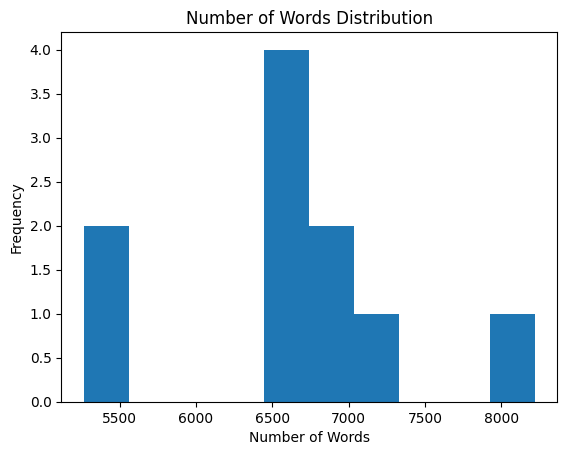

In [4]:
# Loop through each PDF file, convert to plain text, and count the number of words
num_words_list = []
for pdf_file in pdf_files:
    text = extract_text(pdf_file)
    num_words = len(text.split())
    num_words_list.append(num_words)
    print(f'{pdf_file} - Number of words: {num_words}')

# Calculate descriptive statistics
mean_num_words = statistics.mean(num_words_list)
std_num_words = statistics.stdev(num_words_list)

# Print descriptive statistics
print(f'\nNumber of documents: {len(num_words_list)}')
print(f'Mean number of words per document: {mean_num_words:.2f}')
print(f'Standard deviation of number of words per document: {std_num_words:.2f}')

# Generate histogram of word-level sequence lengths for all documents
plt.hist(num_words_list, bins=10)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Number of Words Distribution')
plt.show()

##### Extract Text and Count Words per Participant


Number of documents: 10
Mean number of words per document: 5591.20
Standard deviation of number of words per document: 1097.75


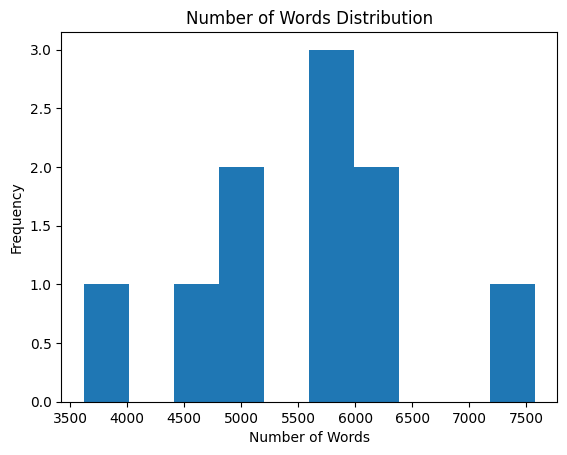

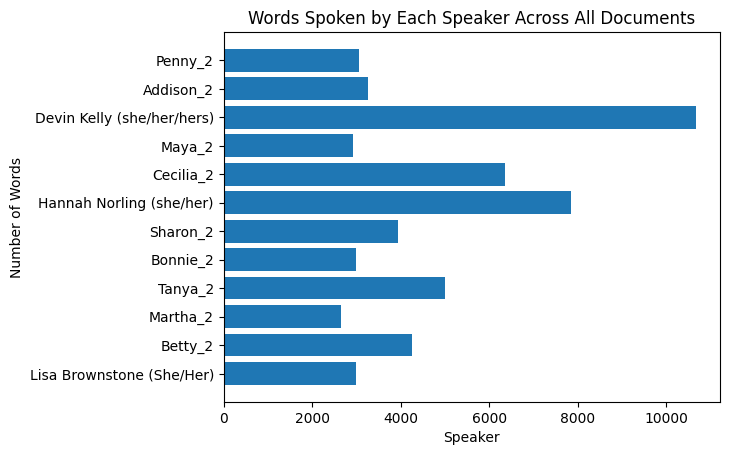

In [5]:
word_counts = {}
speaker_word_counts = defaultdict(int)

for file in pdf_files:
    
    # Reset speaker counts for new file
    speaker_counts = defaultdict(int)
    
    # Reset current speaker
    current_speaker = None
    
    # Extract text
    text = extract_text(file)
    
    # Iterate through text split on new lines
    for line in text.split('\n'):
        
        # Handle empty lines and page numbers
        if not line:
            current_speaker = None
            
        # If this is a meaningful line, process it
        else:
            
            # Check if one of the speakers is speaking
            for speaker in speakers:
                if line.startswith(speaker + ':'):
                    current_speaker = speaker
                    break
            
            # If we have a current speaker, count the number of words in the line
            if current_speaker:
                words = line.split()
                num_words = len(words)
                speaker_counts[current_speaker] += num_words
    
    # Track the total number of words spoken in the file by summing the words from each speaker
    word_counts[file] = sum(speaker_counts.values())
    
    # Track the total number of words spoken by each speaker across documents
    for speaker in speakers:
        speaker_word_counts[speaker] += speaker_counts[speaker]
        
# Calculate descriptive statistics
mean_num_words = statistics.mean(word_counts.values())
std_num_words = statistics.stdev(word_counts.values())

# Print descriptive statistics
print(f'\nNumber of documents: {len(word_counts)}')
print(f'Mean number of words per document: {mean_num_words:.2f}')
print(f'Standard deviation of number of words per document: {std_num_words:.2f}')

# Generate histogram of word-level sequence lengths for all documents
plt.hist(word_counts.values(), bins=10)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Number of Words Distribution')
plt.show()

# Generate bar plot of number of words spoken by each participant
plt.barh(list(speaker_word_counts.keys()), speaker_word_counts.values())
plt.title('Words Spoken by Each Speaker Across All Documents')
plt.xlabel('Speaker')
plt.ylabel('Number of Words')
plt.show()